In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '0792bc5dc0a844f38eacfaafff1f4ab1')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'new balance')
print(results[0])
ims = results.attrgot('content_url')
print(ims[0])
len(ims)

{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=new+balance&id=33B5D0906A6EFF78E7B7E20BD6AA5943470C1BD2&simid=608032816669144451', 'name': 'New Balance Men 990v2 M990DVN2 - Made In USA brown white', 'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.V6Jjt9QGMvszp6WU7Bis3gD6D6&pid=Api', 'datePublished': '2021-01-18T07:24:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'http://d3nt9em9l1urz8.cloudfront.net/media/catalog/product/cache/3/image/1100x/040ec09b1e35df139433887a97daa66f/v/0/v07a9967_1.jpg', 'hostPageUrl': 'http://www.baitme.com/new-balance-men-990v2-m990dvn2-made-in-usa-brown-white-nbm990dvn2-80', 'contentSize': '169057 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'www.baitme.com/new-balance-men-990v2-m990dvn2-made-in-usa-brown-white-nbm990dvn2-80', 'width': 1100, 'height': 1100, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.xRjH6rZoe11Na0GcKp3Ruw&pid=Api', 'hostPageDiscoveredDate': '2016-11-08T00:00:00.0000000Z', 'thumbnai

150

In [6]:
nb_types = '1500','670','577','1300','998'
path = Path('newbalance')

In [9]:
if not path.exists():
    path.mkdir()
    for o in nb_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        print(o)
        results = search_images_bing(key, f'new balance {o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

1500


670


577


1300


998


In [10]:
fns = get_image_files(path)
fns

(#745) [Path('newbalance/577/00000099.jpeg'),Path('newbalance/577/00000047.jpg'),Path('newbalance/577/00000107.jpg'),Path('newbalance/577/00000036.jpg'),Path('newbalance/577/00000030.jpg'),Path('newbalance/577/00000097.jpg'),Path('newbalance/577/00000148.jpg'),Path('newbalance/577/00000110.jpg'),Path('newbalance/577/00000029.jpg'),Path('newbalance/577/00000112.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#30) [Path('newbalance/577/00000110.jpg'),Path('newbalance/577/00000029.jpg'),Path('newbalance/577/00000091.jpg'),Path('newbalance/577/00000093.jpg'),Path('newbalance/577/00000147.jpg'),Path('newbalance/577/00000000.jpg'),Path('newbalance/577/00000088.jpg'),Path('newbalance/577/00000050.jpg'),Path('newbalance/577/00000042.jpg'),Path('newbalance/577/00000013.jpg')...]

In [12]:
failed.map(Path.unlink);

In [13]:
??verify_images

In [14]:
nbs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = nbs.dataloaders(path)

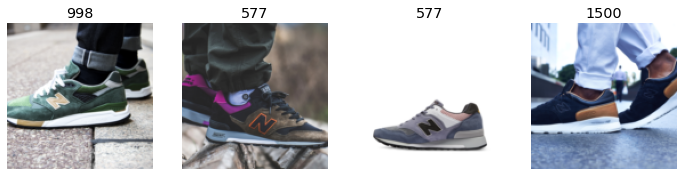

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

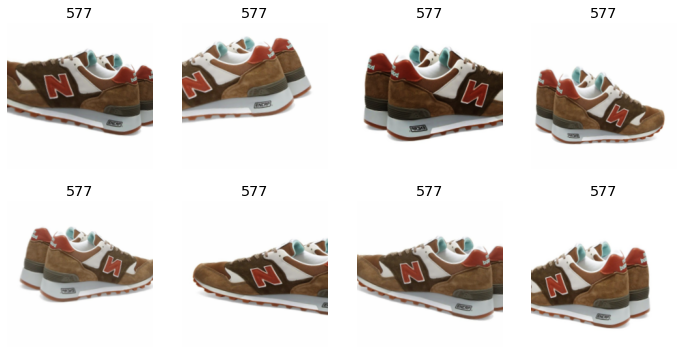

In [17]:
nbs = nbs.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = nbs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.448861,1.687248,0.608392,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.779959,1.315500,0.510490,00:11
1,1.512564,1.108945,0.377622,00:11
2,1.250636,1.005129,0.349650,00:11
3,1.079745,0.965732,0.314685,00:11


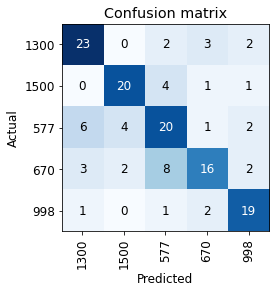

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [20]:
??learn.fine_tune

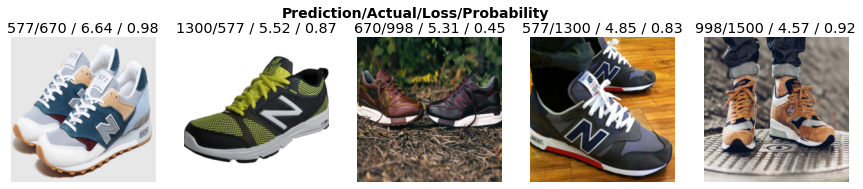

In [21]:
interp.plot_top_losses(5, nrows=1)

In [22]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
print(f'Removing {len(cleaner.delete())} files.')
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Removing 1 files.


In [32]:
dls_clean = nbs.dataloaders(path)
learn.dls = dls_clean

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.757194,0.959691,0.330882,00:11
1,0.593943,1.042793,0.257353,00:10
2,0.504398,1.690586,0.360294,00:10
3,0.452620,0.686633,0.213235,00:10


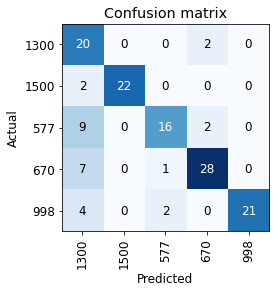

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict('images/nb1300.jpg')

('670',
 TensorImage(3),
 TensorImage([6.6107e-03, 8.2514e-04, 7.1696e-03, 9.7211e-01, 1.3280e-02]))

In [39]:
learn_inf.dls.vocab

['1300', '1500', '577', '670', '998']

In [40]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [41]:
img = PILImage.create(btn_upload.data[-1])

In [42]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [43]:
pred,pred_idx,probs = learn_inf.predict(img)

In [44]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: 998; Probability: 0.9776')

In [45]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [46]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [47]:
btn_upload = widgets.FileUpload()

In [48]:
VBox([widgets.Label('Select nb'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [49]:
    !pip install voila


In [50]:
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.7 OK
